1. Importing Libraries

In [ ]:
## !pip install tensorflow==2.12.0
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adamax, SGD
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (fbeta_score, f1_score, precision_score, recall_score,
                             precision_recall_curve, confusion_matrix, make_scorer,
                            roc_curve, roc_auc_score)
from sklearn.metrics import auc as sklearn_auc
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import make_pipeline
import joblib  # For saving models
import matplotlib.pyplot as plt

2. For importing from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


3. Load and Merge Datasets

In [ ]:
# Set Seeds for Reproducibility
random.seed(1244)
np.random.seed(1244)
tf.random.set_seed(1244)

print("Loading and cleaning data...")

# Load the client and invoice data from CSV files
client_df = pd.read_csv('/content/drive/MyDrive/IT1244 Project/Original Datas/client.csv')
invoice_df = pd.read_csv('/content/drive/MyDrive/IT1244 Project/Original Datas/invoice.csv')

# Convert 'date' columns to datetime format for both datasets
client_df['date'] = pd.to_datetime(client_df['date'], format='%d/%m/%Y')
invoice_df['date'] = pd.to_datetime(invoice_df['date'], format='%d/%m/%Y')

# Handle missing values
client_df = client_df.fillna(method='ffill')  # Forward fill for client data
invoice_df = invoice_df.fillna(0)  # Replace missing values with 0 for invoice data

# Aggregate invoice data by 'id'
print("Aggregating invoice data...")
aggregated_df = invoice_df.groupby('id').agg(
    # Aggregations for consumption levels
    consommation_level_1_sum=('consommation_level_1', 'sum'),
    consommation_level_1_mean=('consommation_level_1', 'mean'),
    consommation_level_1_std=('consommation_level_1', 'std'),
    consommation_level_1_max=('consommation_level_1', 'max'),
    consommation_level_1_min=('consommation_level_1', 'min'),

    consommation_level_2_sum=('consommation_level_2', 'sum'),
    consommation_level_2_mean=('consommation_level_2', 'mean'),
    consommation_level_2_std=('consommation_level_2', 'std'),
    consommation_level_2_max=('consommation_level_2', 'max'),
    consommation_level_2_min=('consommation_level_2', 'min'),

    consommation_level_3_sum=('consommation_level_3', 'sum'),
    consommation_level_3_mean=('consommation_level_3', 'mean'),
    consommation_level_3_std=('consommation_level_3', 'std'),
    consommation_level_3_max=('consommation_level_3', 'max'),
    consommation_level_3_min=('consommation_level_3', 'min'),

    consommation_level_4_sum=('consommation_level_4', 'sum'),
    consommation_level_4_mean=('consommation_level_4', 'mean'),
    consommation_level_4_std=('consommation_level_4', 'std'),
    consommation_level_4_max=('consommation_level_4', 'max'),
    consommation_level_4_min=('consommation_level_4', 'min'),

    # Reading and counter statistics
    reading_remarque_mean=('reading_remarque', 'mean'),
    counter_statue_avg=('counter_statue', 'mean'),
    counter_statue_mode=('counter_statue', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),

    # Transaction information
    total_transactions=('date', 'count'),
    avg_transactions_per_month=('date', lambda x: x.nunique() /
                                ((x.max() - x.min()).days / 30 if (x.max() - x.min()).days != 0 else 1)),
    transaction_period_length_days=('date', lambda x: (x.max() - x.min()).days)
).reset_index()

# Calculate the mode for categorical variables
print("Calculating modes for categorical columns...")
mode_df = invoice_df.groupby('id').agg({
    'tarif_type': lambda x: x.mode()[0],
    'counter_type': lambda x: x.mode()[0],
    'months_number': lambda x: x.mode()[0]
}).reset_index()

# Calculate the unique count for categorical variables
print("Calculating unique counts for categorical variables...")
unique_count_df = invoice_df.groupby('id').agg({
    'tarif_type': 'nunique',  # Unique count
    'counter_type': 'nunique',
    'months_number': 'nunique'
}).reset_index()

# Rename columns for clarity
mode_df.columns = ['id', 'tarif_type_mode', 'counter_type_mode', 'months_number_mode']
unique_count_df.columns = ['id', 'tarif_type_unique_count', 'counter_type_unique_count', 'months_number_unique_count']

# Merge Aggregated, Mode, and Unique Count Data
print("Merging aggregated data...")

final_aggregated_df = aggregated_df.merge(mode_df, on='id').merge(unique_count_df, on='id')

# Merge with Client Data
merged_df = pd.merge(client_df, final_aggregated_df, on='id', how='inner')

# Identify categorical columns (excluding numerical and ordinal ones)
categorical_cols = ['dis', 'catg', 'region', 'months_number_mode', 'counter_type_mode']

# Apply one-hot encoding to categorical columns
print("Applying one-hot encoding to categorical data...")
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

# Export Cleaned Data to CSV
print("Exporting cleaned data to CSV...")
merged_df.to_csv('/content/drive/MyDrive/IT1244 Project/Dataset/cleaned_data.csv', index=False)

# Verify the first few rows of the cleaned DataFrame
print("Cleaned data preview:")
print(merged_df.head())

Loading and cleaning data...


<ipython-input-3-ba30b5271945>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  client_df = client_df.fillna(method='ffill')  # Forward fill for client data


Aggregating invoice data...
Calculating modes for categorical columns...
Calculating unique counts for categorical variables...
Merging aggregated data...
Applying one-hot encoding to categorical data...
Exporting cleaned data to CSV...
Cleaned data preview:
        date    id  target  consommation_level_1_sum  \
0 1994-12-31     0       0                     12334   
1 2002-05-29     1       0                     20629   
2 1986-03-13    10       0                     14375   
3 1996-07-11   100       0                        24   
4 2014-10-14  1000       0                      9292   

   consommation_level_1_mean  consommation_level_1_std  \
0                 352.400000                310.343472   
1                 557.540541                197.935960   
2                 798.611111                513.841374   
3                   1.200000                  3.607011   
4                 663.714286                224.831365   

   consommation_level_1_max  consommation_level_1_min  

4. Input your file dir that you stored the cleaned_data

In [ ]:
# For implementation by examiner
# merged_df = pd.read_csv('your dir for cleaned_data')

5. Preparing Data for Modeling

In [ ]:
# Prepare data for modeling, dropping unnecessary columns
X = merged_df.drop(['id', 'date', 'target'], axis=1)
y = merged_df['target']

# Standardizing the features
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1244)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure X and y are NumPy arrays to avoid indexing errors
X_train = np.array(X_train)
y_train = np.array(y_train)

6. Data Balancing


Imbalance Ratios for Each Method:
original: 19.12
SMOTE only: 1.00
TOMEK only: 18.68
SMOTE + TOMEK: 1.00
SMOTEENN only: 1.33

Best Resampling Method: SMOTE only with Imbalance Ratio: 1.00


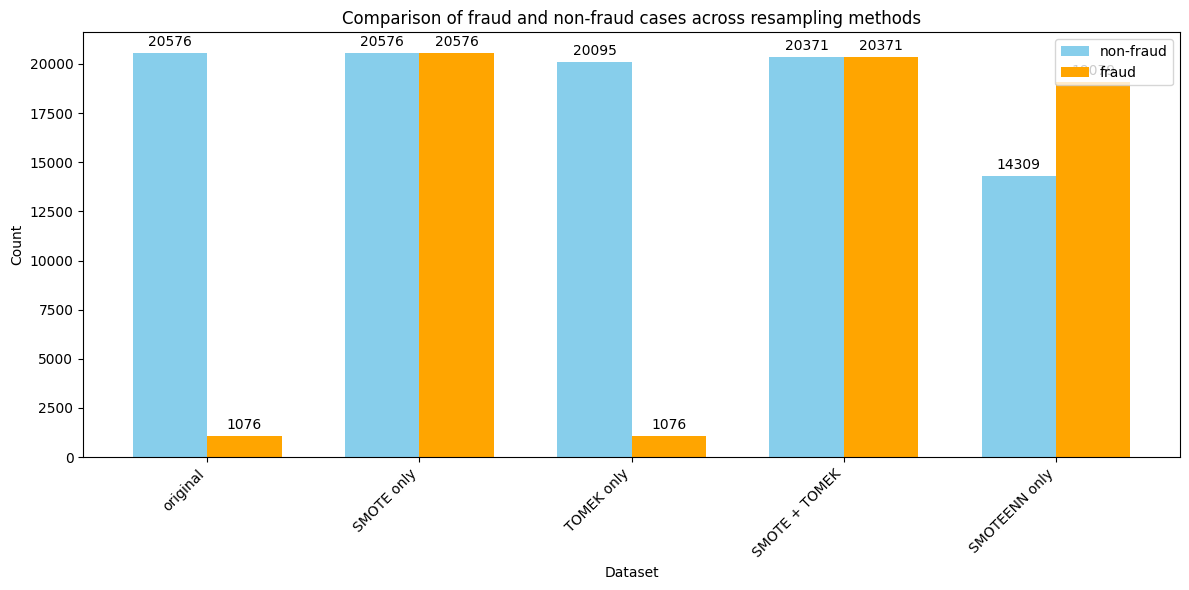

In [ ]:
# Calculate Imbalance Ratio
def calculate_imbalance_ratio(y):
    """Calculate the imbalance ratio (majority/minority)."""
    classes, counts = np.unique(y, return_counts=True)
    imbalance_ratio = max(counts) / min(counts)
    return imbalance_ratio

# Plot Class Distribution
def plot_comparison_bar_chart(distributions):
    """Plot a bar chart comparing fraud and non-fraud cases for multiple resampling methods."""
    plt.figure(figsize=(12, 6))

    # Extract data for plotting
    datasets = list(distributions.keys())
    counts_non_fraud = [dist[0] for dist in distributions.values()]
    counts_fraud = [dist[1] for dist in distributions.values()]

    # Plot bars for non-fraud and fraud cases
    bar_width = 0.35
    indices = np.arange(len(datasets))

    plt.bar(indices - bar_width/2, counts_non_fraud, width=bar_width, label='non-fraud', color='skyblue')
    plt.bar(indices + bar_width/2, counts_fraud, width=bar_width, label='fraud', color='orange')

    # Add labels, title, and legend
    plt.xlabel('Dataset')
    plt.ylabel('Count')
    plt.title('Comparison of fraud and non-fraud cases across resampling methods')
    plt.xticks(indices, datasets, rotation=45, ha='right')
    plt.legend()

    # Display counts on top of bars
    for i, (count_non_fraud, count_fraud) in enumerate(zip(counts_non_fraud, counts_fraud)):
        plt.text(i - bar_width/2, count_non_fraud + 200, str(count_non_fraud), ha='center', va='bottom')
        plt.text(i + bar_width/2, count_fraud + 200, str(count_fraud), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Apply All Possible Combinations of Resampling Methods
def compare_all_resampling_methods(X, y):
    """Apply all possible combinations of SMOTE, Tomek Links, and SMOTEENN."""
    distributions = {}
    imbalance_ratios = {}

    # Original dataset
    classes, counts = np.unique(y, return_counts=True)
    distributions['original'] = counts
    imbalance_ratios['original'] = calculate_imbalance_ratio(y)

    # SMOTE only
    smote = SMOTE(random_state=1244)
    X_smote, y_smote = smote.fit_resample(X, y)
    classes, counts = np.unique(y_smote, return_counts=True)
    distributions['SMOTE only'] = counts
    imbalance_ratios['SMOTE only'] = calculate_imbalance_ratio(y_smote)

    # Tomek Links only
    tomek = TomekLinks()
    X_tomek, y_tomek = TomekLinks(sampling_strategy='majority').fit_resample(X, y)
    classes, counts = np.unique(y_tomek, return_counts=True)
    distributions['TOMEK only'] = counts
    imbalance_ratios['TOMEK only'] = calculate_imbalance_ratio(y_tomek)

    # SMOTE + Tomek Links
    X_smote_tomek, y_smote_tomek = SMOTETomek(random_state=1244).fit_resample(X, y)
    classes, counts = np.unique(y_smote_tomek, return_counts=True)
    distributions['SMOTE + TOMEK'] = counts
    imbalance_ratios['SMOTE + TOMEK'] = calculate_imbalance_ratio(y_smote_tomek)

    # SMOTEENN only
    smoteenn = SMOTEENN(sampling_strategy='auto', random_state=1244)
    X_smoteenn, y_smoteenn = smoteenn.fit_resample(X, y)
    classes, counts = np.unique(y_smoteenn, return_counts=True)
    distributions['SMOTEENN only'] = counts
    imbalance_ratios['SMOTEENN only'] = calculate_imbalance_ratio(y_smoteenn)

    return distributions, imbalance_ratios

# Run the Comparison and Plot the Results
distributions, imbalance_ratios = compare_all_resampling_methods(X, y)

# Print all imbalance ratios
print("\nImbalance Ratios for Each Method:")
for method, ratio in imbalance_ratios.items():
    print(f"{method}: {ratio:.2f}")

# Find and print the best method with the lowest imbalance ratio
best_method = min(imbalance_ratios, key=imbalance_ratios.get)
print(f"\nBest Resampling Method: {best_method} with Imbalance Ratio: {imbalance_ratios[best_method]:.2f}")

# Plot the class distribution bar chart
plot_comparison_bar_chart(distributions)

In [ ]:
# Balancing method
def apply_balancing(X_train, y_train, method='smoteenn'):
    """Apply data balancing techniques to the training data."""
    if method == 'smote':
        X_res, y_res = SMOTE(random_state=1244).fit_resample(X_train, y_train)
    elif method == 'tomek':
        X_res, y_res = TomekLinks(sampling_strategy='majority').fit_resample(X_train, y_train)
    elif method == 'smoteenn':
        X_res, y_res = SMOTEENN(sampling_strategy='auto', random_state=1244).fit_resample(X_train, y_train)
    elif method == 'smotetomek':
        X_res, y_res = SMOTETomek(random_state=1244).fit_resample(X_train, y_train)

    # Reset the indices to avoid KeyErrors during future operations
    X_res = np.array(X_res)
    y_res = np.array(y_res)

    # Print the shapes for verification
    print(f"After {method} resampling: X shape = {X_res.shape}, y shape = {y_res.shape}")

    return X_res, y_res

# Balancing X_train and y_train for final model training
X_SMOTEENN, y_SMOTEENN = apply_balancing(X_train, y_train, method='smoteenn')
X_SMOTETOMEK, y_SMOTETOMEK = apply_balancing(X_train, y_train, method='smotetomek')

After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)
After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


7. Modelling using K-Nearest Neighbours Classifier, Logistical Regression and Random Forest Classifier

a. Result Storing

In [ ]:
# Placeholder to store metrics for comparison
results = {
    'SMOTEENN': {},
    'SMOTETOMEK': {}
}

pr_curves = {  # Store PR curve data for all datasets and models
    'SMOTEENN': {},
    'SMOTETOMEK': {}
}

best_params_store = {}  # Store best hyperparameters for future usage


b. Hyperparameter Grid

In [ ]:
# Define F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Parameter grids
knn_param_grid = {
    'n_neighbors': [i for i in range(21, 148, 2)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'kd_tree'],
    'leaf_size': [10, 30]
}

# Define parameter grid with valid combinations
logistic_regression_param_grid = [
    {  # For 'liblinear' solver
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'class_weight': ['balanced'],
        'max_iter': [100, 500],
        'fit_intercept': [True],
        'tol': [1e-4, 1e-3]
    },
    {  # For 'saga' solver with elasticnet
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        'class_weight': ['balanced'],
        'max_iter': [500],
        'fit_intercept': [True],
        'tol': [1e-4],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    {  # For 'saga' solver with l1 or l2 penalties
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10],
        'class_weight': ['balanced'],
        'max_iter': [500],
        'fit_intercept': [True],
        'tol': [1e-4]
    }
]

random_forest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced']
}

c. Threshold Optimization

In [ ]:
def find_optimal_threshold_for_f2(y_true, y_prob):
    """Find the optimal threshold from the Precision-Recall Curve to maximize F2 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # Safely calculate F2 scores by handling division-by-zero cases
    with np.errstate(divide='ignore', invalid='ignore'):
        f2_scores = np.where(
            (precision + recall) == 0,
            0,  # Avoid division by zero
            (5 * precision * recall) / (4 * precision + recall)
        )

    optimal_idx = np.argmax(f2_scores)  # Index of the highest F2 score
    optimal_threshold = thresholds[optimal_idx] if len(thresholds) > 0 else 0.5  # Default to 0.5 if no thresholds

    return optimal_threshold

d. Model Training and Evaluation

In [ ]:
def evaluate_with_cv(model, param_grid, X, y, model_name, dataset_name):
    """Evaluate model using cross-validation with per-fold SMOTEENN balancing."""

    print(f"Training {model_name} on {dataset_name} using RandomizedSearchCV...\n")

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1244)

    # Use RandomizedSearchCV for hyperparameter optimization
    random_search = RandomizedSearchCV(
        model, param_distributions=param_grid, n_iter=5,
        scoring=f2_scorer, cv=skf, verbose=1, n_jobs=-1,
        random_state=1244
    )
    random_search.fit(X, y)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # Ensure the correct storage of best hyperparameters
    if model_name not in best_params_store:
        best_params_store[model_name] = {}
    best_params_store[model_name][dataset_name] = best_params

    print(f"Best hyperparameters for {model_name} on {dataset_name}: {best_params}\n")

    fold_metrics = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Processing Fold {fold_idx + 1}...\n")

        # Extract train/validation sets and reset indices
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        # Apply SMOTEENN only to the training data
        X_resampled, y_resampled = apply_balancing(X_fold_train, y_fold_train, method=dataset_name.lower())

        # Train the model on resampled data
        best_model.fit(X_resampled, y_resampled)

        # Predict probabilities on the validation set
        y_prob = best_model.predict_proba(X_fold_val)[:, 1]

        # Find the optimal threshold for F2 score
        optimal_threshold = find_optimal_threshold_for_f2(y_fold_val, y_prob)
        print(f"Optimal Threshold for Fold {fold_idx + 1}: {optimal_threshold:.2f}")

        # Make predictions using the optimized threshold
        y_pred = (y_prob >= optimal_threshold).astype(int)

        # Display the confusion matrix for this fold
        cm = confusion_matrix(y_fold_val, y_pred)
        print(f"Confusion Matrix for Fold {fold_idx + 1}:\n{cm}\n")

        # Calculate and store metrics for the fold
        f1 = f1_score(y_fold_val, y_pred)
        f2 = fbeta_score(y_fold_val, y_pred, beta=2)
        precision = precision_score(y_fold_val, y_pred)
        recall = recall_score(y_fold_val, y_pred)
        pr_precision, pr_recall, _ = precision_recall_curve(y_fold_val, y_prob)
        pr_auc = sklearn_auc(pr_recall, pr_precision)

        fold_metrics.append((f1, f2, precision, recall, pr_auc))

    # Aggregate metrics across folds
    f1_avg, f2_avg, precision_avg, recall_avg, pr_auc_avg = np.mean(fold_metrics, axis=0)

    results[dataset_name][model_name] = {
        'f1': f1_avg, 'f2': f2_avg,
        'precision': precision_avg, 'recall': recall_avg,
        'pr_auc': pr_auc_avg
    }
    pr_curves[dataset_name][model_name] = {
        'precision': pr_precision, 'recall': pr_recall, 'pr_auc': pr_auc_avg
    }

    print(f"{model_name} on {dataset_name}:\n"
          f"F1 Score: {f1_avg:.2f}\nF2 Score: {f2_avg:.2f}\n"
          f"Precision: {precision_avg:.2f}\nRecall: {recall_avg:.2f}\n"
          f"PR AUC: {pr_auc_avg:.2f}\n")

def evaluate_on_balanced_data_cv(X, y, dataset_name):
    """Evaluate models using cross-validation with per-fold SMOTEENN balancing."""
    models = {
        'KNN': KNeighborsClassifier(),
        'Logistic_Regression': LogisticRegression(max_iter=1000),
        'Random_Forest': RandomForestClassifier(random_state=1244)
    }
    param_grids = {
        'KNN': knn_param_grid,
        'Logistic_Regression': logistic_regression_param_grid,
        'Random_Forest': random_forest_param_grid
    }

    for name, model in models.items():
        print(f"Evaluating {name} on {dataset_name}...\n")
        evaluate_with_cv(model, param_grids[name], X, y, name, dataset_name)

# Ensure X and y are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Evaluate models on the dataset
evaluate_on_balanced_data_cv(X_train, y_train, 'SMOTEENN')
evaluate_on_balanced_data_cv(X_train, y_train, 'SMOTETOMEK')

Evaluating KNN on SMOTEENN...

Training KNN on SMOTEENN using RandomizedSearchCV...

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters for KNN on SMOTEENN: {'weights': 'uniform', 'n_neighbors': 65, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'kd_tree'}

Processing Fold 1...

After smoteenn resampling: X shape = (18944, 81), y shape = (18944,)
Optimal Threshold for Fold 1: 0.55
Confusion Matrix for Fold 1:
[[3323 2161]
 [  84  206]]

Processing Fold 2...

After smoteenn resampling: X shape = (19115, 81), y shape = (19115,)
Optimal Threshold for Fold 2: 0.51
Confusion Matrix for Fold 2:
[[3286 2198]
 [  92  198]]

Processing Fold 3...

After smoteenn resampling: X shape = (19020, 81), y shape = (19020,)
Optimal Threshold for Fold 3: 0.65
Confusion Matrix for Fold 3:
[[3815 1668]
 [ 108  182]]

KNN on SMOTEENN:
F1 Score: 0.16
F2 Score: 0.29
Precision: 0.09
Recall: 0.67
PR AUC: 0.12

Evaluating Logistic_Regression on SMOTEENN...

Training Logistic_Re

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters for Logistic_Regression on SMOTEENN: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.1, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}

Processing Fold 1...

After smoteenn resampling: X shape = (18944, 81), y shape = (18944,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 1: 0.65
Confusion Matrix for Fold 1:
[[4277 1207]
 [ 132  158]]

Processing Fold 2...

After smoteenn resampling: X shape = (19115, 81), y shape = (19115,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 2: 0.53
Confusion Matrix for Fold 2:
[[3635 1849]
 [  99  191]]

Processing Fold 3...

After smoteenn resampling: X shape = (19020, 81), y shape = (19020,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 3: 0.59
Confusion Matrix for Fold 3:
[[3919 1564]
 [ 103  187]]

Logistic_Regression on SMOTEENN:
F1 Score: 0.18
F2 Score: 0.31
Precision: 0.11
Recall: 0.62
PR AUC: 0.12

Evaluating Random_Forest on SMOTEENN...

Training Random_Forest on SMOTEENN using RandomizedSearchCV...

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters for Random_Forest on SMOTEENN: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}

Processing Fold 1...

After smoteenn resampling: X shape = (18944, 81), y shape = (18944,)
Optimal Threshold for Fold 1: 0.38
Confusion Matrix for Fold 1:
[[3568 1916]
 [  74  216]]

Processing Fold 2...

After smoteenn resampling: X shape = (19115, 81), y shape = (19115,)
Optimal Threshold for Fold 2: 0.36
Confusion Matrix for Fold 2:
[[3556 1928]
 [  88  202]]

Processing Fold 3...

After smoteenn re

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters for Logistic_Regression on SMOTETOMEK: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.1, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}

Processing Fold 1...

After smotetomek resampling: X shape = (21888, 81), y shape = (21888,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 1: 0.59
Confusion Matrix for Fold 1:
[[4166 1318]
 [ 128  162]]

Processing Fold 2...

After smotetomek resampling: X shape = (21890, 81), y shape = (21890,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 2: 0.51
Confusion Matrix for Fold 2:
[[3681 1803]
 [ 100  190]]

Processing Fold 3...

After smotetomek resampling: X shape = (21894, 81), y shape = (21894,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal Threshold for Fold 3: 0.53
Confusion Matrix for Fold 3:
[[3741 1742]
 [  97  193]]

Logistic_Regression on SMOTETOMEK:
F1 Score: 0.17
F2 Score: 0.31
Precision: 0.10
Recall: 0.63
PR AUC: 0.12

Evaluating Random_Forest on SMOTETOMEK...

Training Random_Forest on SMOTETOMEK using RandomizedSearchCV...

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters for Random_Forest on SMOTETOMEK: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}

Processing Fold 1...

After smotetomek resampling: X shape = (21888, 81), y shape = (21888,)
Optimal Threshold for Fold 1: 0.36
Confusion Matrix for Fold 1:
[[3537 1947]
 [  79  211]]

Processing Fold 2...

After smotetomek resampling: X shape = (21890, 81), y shape = (21890,)
Optimal Threshold for Fold 2: 0.39
Confusion Matrix for Fold 2:
[[3715 1769]
 [  99  191]]

Processing Fold 3...

After

8. Deep Learning Model (Feedforward Neural Network (FNN), also known as a Dense Neural Network)

In [ ]:
# Optimizer dictionary for easy access
optimizers_dict = {
    'adam': Adam, 'rmsprop': RMSprop, 'nadam': Nadam,
    'adamax': Adamax, 'sgd': SGD
}

# Build the Feedforward Neural Network model
def build_fnn_model(optimizer='adam', dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_instance = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Random search for best FNN configuration
def find_best_fnn_config(X_train, y_train, param_grid, n_iter, dataset_name):
    best_score = -np.inf
    best_params = None

    # Perform a random search over the parameter space
    for i in range(n_iter):
        # Randomly select hyperparameters
        optimizer = random.choice(param_grid['optimizer'])
        learning_rate = random.choice(param_grid['learning_rate'])
        dropout_rate = random.choice(param_grid['dropout_rate'])
        epochs = random.choice(param_grid['epochs'])
        batch_size = random.choice(param_grid['batch_size'])

        # Apply balancing to the entire training set
        X_resampled, y_resampled = apply_balancing(X_train, y_train, method=dataset_name.lower())

        # Build and train the model with the current configuration
        model = build_fnn_model(optimizer, dropout_rate, learning_rate)
        model.fit(X_resampled, y_resampled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Evaluate the model on the training set
        y_prob = model.predict(X_resampled).flatten()

        # Find the optimal threshold for F2 score
        optimal_threshold = find_optimal_threshold_for_f2(y_resampled, y_prob)

        # Make predictions based on optimized threshold
        y_pred = (y_prob >= optimal_threshold).astype(int)
        f2 = fbeta_score(y_resampled, y_pred, beta=2)

        # Update the best configuration if the current one performs better
        if f2 > best_score:
            best_score = f2
            best_params = {
                'optimizer': optimizer,
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'epochs': epochs,
                'batch_size': batch_size
            }

    print(f"\nBest FNN Configuration for {dataset_name}: {best_params}")
    return best_params

# Perform 3-fold cross-validation using the best configuration
def evaluate_best_fnn(X_train, y_train, dataset_name):
    print(f"Evaluating FNN on {dataset_name} with best configuration...\n")

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1244)
    fold_metrics = []
    all_precision_recall = []  # To store precision-recall pairs for each fold

    # Find the best FNN configuration
    best_params = find_best_fnn_config(X_train, y_train, fnn_param_grid, 5, dataset_name)

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Processing Fold {fold_idx + 1}...\n")

        # Split into training and validation sets
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Apply balancing only on the training fold
        X_resampled, y_resampled = apply_balancing(X_fold_train, y_fold_train, method=dataset_name.lower())

        # Build and train the model with the best parameters
        model = build_fnn_model(
            optimizer=best_params['optimizer'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        model.fit(X_resampled, y_resampled, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

        # Predict probabilities on the validation set
        y_prob = model.predict(X_fold_val).flatten()

        # Find the optimal threshold for F2 score
        optimal_threshold = find_optimal_threshold_for_f2(y_fold_val, y_prob)
        print(f"Optimal Threshold for Fold {fold_idx + 1}: {optimal_threshold:.2f}")

        # Make predictions using the optimized threshold
        y_pred = (y_prob >= optimal_threshold).astype(int)

        # Print the confusion matrix for this fold
        cm = confusion_matrix(y_fold_val, y_pred)
        print(f"Confusion Matrix for Fold {fold_idx + 1}:\n{cm}\n")

        # Calculate metrics for the fold
        precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
        ap_score = sklearn_auc(recall, precision)
        f1 = f1_score(y_fold_val, y_pred)
        f2 = fbeta_score(y_fold_val, y_pred, beta=2)
        precision_value = precision_score(y_fold_val, y_pred)
        recall_value = recall_score(y_fold_val, y_pred)

        fold_metrics.append((f1, f2, precision_value, recall_value, ap_score))
        all_precision_recall.append((precision, recall))  # Store precision-recall curves

    # Aggregate metrics across folds
    f1_avg, f2_avg, precision_avg, recall_avg, pr_auc_avg = np.mean(fold_metrics, axis=0)

    # Store the results
    results[dataset_name]['FNN'] = {
        'f1': f1_avg, 'f2': f2_avg,
        'precision': precision_avg, 'recall': recall_avg,
        'pr_auc': pr_auc_avg
    }

    # Store the PR curve data (use the final fold's PR curve for visualization)
    pr_curves[dataset_name]['FNN'] = {
        'precision': all_precision_recall[-1][0],  # Precision from last fold
        'recall': all_precision_recall[-1][1],     # Recall from last fold
        'pr_auc': pr_auc_avg
    }

    print(f"\nFinal FNN Metrics for {dataset_name}:\n"
          f"F1: {f1_avg:.2f}, F2: {f2_avg:.2f}\n"
          f"Precision: {precision_avg:.2f}\nRecall: {recall_avg:.2f}\n"
          f"PR AUC: {pr_auc_avg:.2f}\n")

    # Store the best parameters for FNN
    best_params_store['FNN'] = {dataset_name: best_params}

# Define parameter grid for FNN
fnn_param_grid = {
    'optimizer': ['adam', 'rmsprop', 'nadam', 'adamax', 'sgd'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.5, 0.7],
    'epochs': [10, 20, 30, 50],
    'batch_size': [8, 16, 32, 64]
}

# Evaluate the FNN using 3-fold CV with the best configuration
evaluate_best_fnn(X_train, y_train, 'SMOTEENN')
evaluate_best_fnn(X_train, y_train, 'SMOTETOMEK')

# Print best hyperparameters and metrics summary
print("\nBest Hyperparameters:\n")
for model_name, dataset_params in best_params_store.items():
    for dataset, params in dataset_params.items():
        print(f"{model_name} on {dataset}: {params}\n")

# Print final metrics summary
print("\nFinal Metrics Summary:\n")
for dataset_name, models in results.items():
    print(f"{dataset_name} Results:\n")
    for model_name, metrics in models.items():
        print(f"{model_name}:\n"
              f"F1: {metrics['f1']:.2f}\n"
              f"F2: {metrics['f2']:.2f}\n"
              f"Precision: {metrics['precision']:.2f}\n"
              f"Recall: {metrics['recall']:.2f}\n"
              f"PR AUC: {metrics['pr_auc']:.2f}\n")

Evaluating FNN on SMOTEENN with best configuration...

After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smoteenn resampling: X shape = (28515, 81), y shape = (28515,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Best FNN Configuration for SMOTEENN: {'optimizer': 'rmsprop', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'epochs': 20, 'batch_size': 16}
Processing Fold 1...

After smoteenn resampling: X shape = (18944, 81), y shape = (18944,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal Threshold for Fold 1: 0.66
Confusion Matrix for Fold 1:
[[3143 2341]
 [  69  221]]

Processing Fold 2...

After smoteenn resampling: X shape = (19115, 81), y shape = (19115,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal Threshold for Fold 2: 0.29
Confusion Matrix for Fold 2:
[[3784 1700]
 [ 124  166]]

Processing Fold 3...

After smoteenn resampling: X shape = (19020, 81), y shape = (19020,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal Threshold for Fold 3: 0.44
Confusion Matrix for Fold 3:
[[3358 2125]
 [  84  206]]


Final FNN Metrics for SMOTEENN:
F1: 0.16, F2: 0.29
Precision: 0.09
Recall: 0.68
PR AUC: 0.10

Evaluating FNN on SMOTETOMEK with best configuration...

After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
After smotetomek resampling: X shape = (32832, 81), y shape = (32832,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Best FNN Configuration for SMOTETOMEK: {'optimizer': 'adamax', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'epochs': 50, 'batch_size': 64}
Processing Fold 1...

After smotetomek resampling: X shape = (21888, 81), y shape = (21888,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal Threshold for Fold 1: 0.49
Confusion Matrix for Fold 1:
[[4455 1029]
 [ 150  140]]

Processing Fold 2...

After smotetomek resampling: X shape = (21890, 81), y shape = (21890,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimal Threshold for Fold 2: 0.48
Confusion Matrix for Fold 2:
[[4300 1184]
 [ 152  138]]

Processing Fold 3...

After smotetomek resampling: X shape = (21894, 81), y shape = (21894,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal Threshold for Fold 3: 0.41
Confusion Matrix for Fold 3:
[[3890 1593]
 [ 106  184]]


Final FNN Metrics for SMOTETOMEK:
F1: 0.18, F2: 0.30
Precision: 0.11
Recall: 0.53
PR AUC: 0.12


Best Hyperparameters:

KNN on SMOTEENN: {'weights': 'uniform', 'n_neighbors': 65, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'kd_tree'}

KNN on SMOTETOMEK: {'weights': 'uniform', 'n_neighbors': 65, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'kd_tree'}

Logistic_Regression on SMOTEENN: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.1, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}

Logistic_Regression on SMOTETOMEK: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.1, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}

Random_Forest on SMOTEENN: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2

9. Plot Precision-Recall Curves for All Models

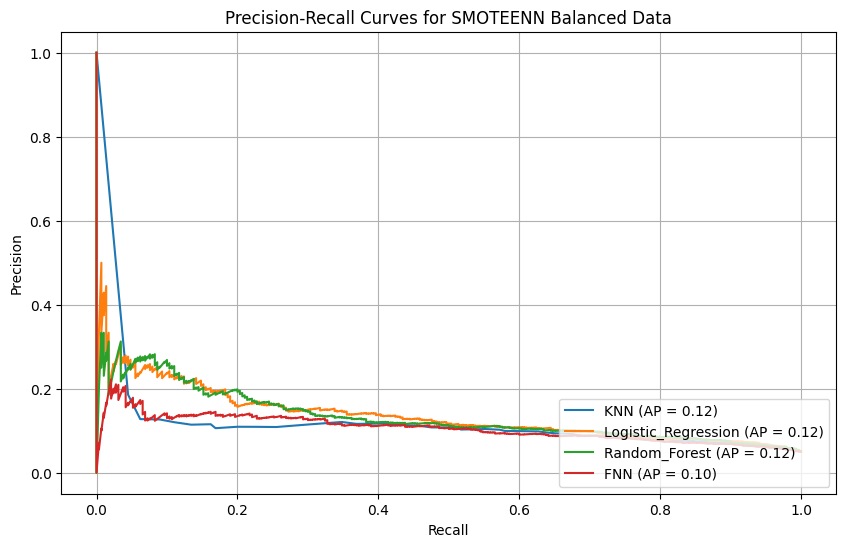

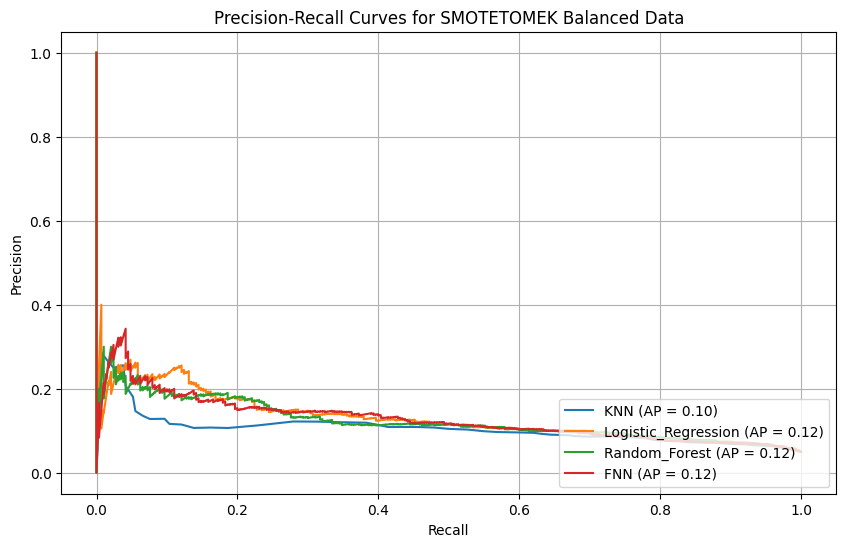

In [ ]:
def plot_stored_pr_curves(pr_curves, dataset_name):
    """
    Plot PR curves for all models using stored precision-recall data.

    Args:
    - pr_curves (dict): Dictionary containing precision-recall curve data for all datasets and models.
    - dataset_name (str): Name of the dataset for which to plot PR curves.

    Returns:
    - None. Displays the plot with PR curves.
    """

    # Check if the dataset exists in the pr_curves dictionary
    if dataset_name not in pr_curves:
        print(f"No PR curves found for dataset: {dataset_name}")
        return  # Exit if the dataset is not found

    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    # Iterate over all models in the specified dataset
    for model_name, curve_data in pr_curves[dataset_name].items():
        try:
            # Extract precision, recall, and PR AUC values from the dictionary
            precision = curve_data['precision']
            recall = curve_data['recall']
            pr_auc = curve_data['pr_auc']

            # Plot the precision-recall curve for the current model
            plt.plot(recall, precision, label=f'{model_name} (AP = {pr_auc:.2f})')

        except KeyError as e:
            # Handle missing keys in the dictionary and print a warning
            print(f"Missing data for {model_name}: {e}")

    # Set plot labels and title for clarity
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {dataset_name} Balanced Data')

    # Add a legend to distinguish between models
    plt.legend(loc='lower right')

    # Add a grid to the plot for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

# Plot PR curves for the SMOTEENN dataset
plot_stored_pr_curves(pr_curves, 'SMOTEENN')
plot_stored_pr_curves(pr_curves, 'SMOTETOMEK')

10. Saving Final Trained Models

In [ ]:
# Load the best parameters from the `best_params_store`
best_rf_params = best_params_store['Random_Forest']['SMOTEENN']
print(f"Best Random Forest Parameters: {best_rf_params}")

# Train the final Random Forest model on the entire SMOTEENN dataset
print("Training the final Random Forest model with the best parameters on SMOTEENN...")

rf_final_model = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    bootstrap=best_rf_params['bootstrap'],
    criterion=best_rf_params['criterion'],
    class_weight=best_rf_params['class_weight'],
    random_state=1244
)

# Fit the final model using the entire SMOTEENN dataset
rf_final_model.fit(X_SMOTEENN, y_SMOTEENN)

# Save the trained model to the specified directory
joblib.dump(rf_final_model, '/content/drive/MyDrive/IT1244 Project/Models/rf_final_model.pkl')
print("Model saved to: /content/drive/MyDrive/IT1244 Project/Models/rf_final_model.pkl")

Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Training the final Random Forest model with the best parameters on SMOTEENN...
Model saved to: /content/drive/MyDrive/IT1244 Project/Models/rf_final_model.pkl


11. Evaluating on Final Trained Model with 20% of Test Data (unseen from model during previous training and evaluation)


Evaluating the final model on the test set...
Optimal Threshold for Random Forest Classification: 0.49

Confusion Matrix (Test Set):
[[3083 1042]
 [  73  133]]


Test Set Metrics:
Accuracy: 0.74
F1 Score: 0.19
F2 Score: 0.33
Precision: 0.11
Recall: 0.65
PR AUC: 0.14
AUC ROC: 0.76



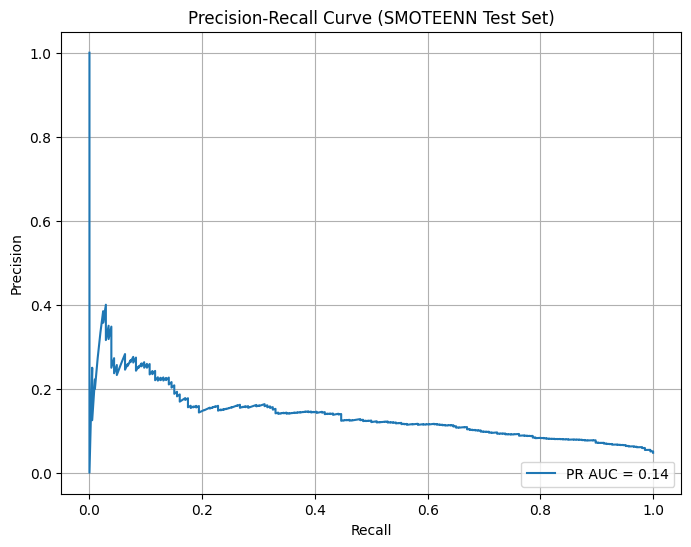

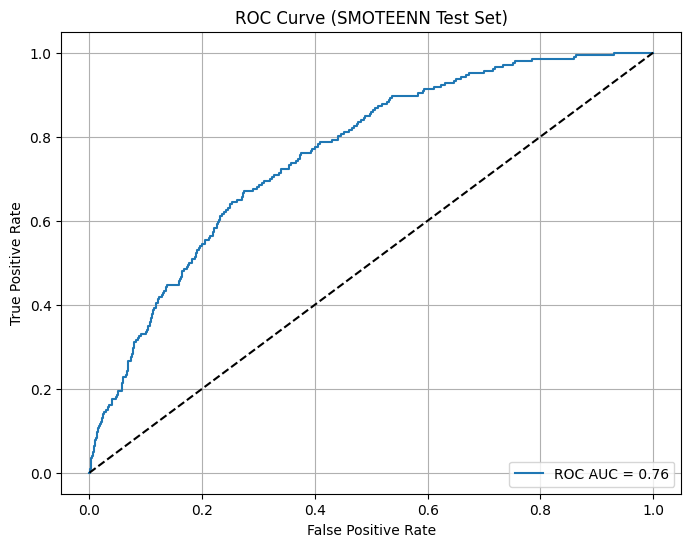

In [ ]:
# Evaluate the final model using the X_test and y_test data
print("\nEvaluating the final model on the test set...")

# Predict probabilities on the test set
y_prob_test = rf_final_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Find the optimal threshold for F2 score
test_optimal_threshold = find_optimal_threshold_for_f2(y_test, y_prob_test)
print(f"Optimal Threshold for Random Forest Classification: {test_optimal_threshold:.2f}")

# Make predictions using the optimized threshold
y_pred_test = (y_prob_test >= test_optimal_threshold).astype(int)

# Calculate metrics on the test set
f1_test = f1_score(y_test, y_pred_test)
f2_test = fbeta_score(y_test, y_pred_test, beta=2)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
accuracy_test = (y_test == y_pred_test).mean()
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob_test)
pr_auc_test = sklearn_auc(recall_curve, precision_curve)
auc_roc_test = roc_auc_score(y_test, y_prob_test)

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix (Test Set):\n{cm_test}\n")

# Print the metrics
print(f"\nTest Set Metrics:\n"
      f"Accuracy: {accuracy_test:.2f}\n"
      f"F1 Score: {f1_test:.2f}\n"
      f"F2 Score: {f2_test:.2f}\n"
      f"Precision: {precision_test:.2f}\n"
      f"Recall: {recall_test:.2f}\n"
      f"PR AUC: {pr_auc_test:.2f}\n"
      f"AUC ROC: {auc_roc_test:.2f}\n")

# Plot the Precision-Recall curve for the test set
def plot_pr_curve(precision, recall, pr_auc):
    """Plot the PR curve with AUC."""
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (SMOTEENN Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot the ROC curve for the test set
def plot_roc_curve(y_true, y_prob):
    """Plot the ROC curve with AUC."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)  # Calculate FPR, TPR
    roc_auc = sklearn_auc(fpr, tpr)  # Calculate AUC

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SMOTEENN Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot the PR curve for the test set
plot_pr_curve(precision_curve, recall_curve, pr_auc_test)
plot_roc_curve(y_test, y_prob_test)